#Machine Learning Analysis of Canadian Turbine Dataset 

#Introduction:



From this information we will now re-highlight the overall purpose or overarching problem statements of our analysis:

*What highly accurate (or optimal) model can help us to best predict the total capacity associated with each of the dataset's major projects*

*What highly accurate (or optimal) model can help us to best classify the manufacturers of the highest performing (or most high power generating) turbines?*

*Note: We have run our cells multiple times over to test if our code worked synergistically as such all testing accuracies and numerical outputs are in close approximation to our original run of the code.*

Importing all necessary libraries for our analysis.

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from keras import models, layers, callbacks
from keras.models import load_model
import statsmodels.api as sm, statsmodels.formula.api as smf, statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.regressionplots import *
import seaborn as sns
import matplotlib.pyplot as plt
import math, os, shutil, pickle as pk, scipy.stats as stats, researchpy as rp
from numpy.random import seed, randn
from scipy.stats import lognorm

#Part I: Regression Modelling For Turbine Dataset

Before we begin our analysis of this dataset it is important to firstly ensure that our dataset can meet the regression assumptions, this is imperative as without these assumptions our dataset will not be accurately modelled.

1. Check for linearity

In [20]:
data = pd.read_csv('Turbine.csv')
data = data[['Turbine rated capacity (kW)', 'Rotor diameter (m)', 'Hub height (m)','Total project capacity (MW)']]
data  = data.rename(columns={'Turbine rated capacity (kW)':'turbineCapacity', 'Rotor diameter (m)':'rotorDiametre','Hub height (m)':'hubHeight', 'Total project capacity (MW)':'projectCapacity'})

data['turbineCapacity'] = pd.to_numeric(data['turbineCapacity'], errors='coerce')
data = data.dropna()
data['turbineCapacity'] = data['turbineCapacity'].astype(float)
data

,turbineCapacity,rotorDiametre,hubHeight,projectCapacity
0,150.0,23.0,30.0,0.90
1,600.0,44.0,40.0,44.00
2,600.0,44.0,50.0,3.78
3,600.0,44.0,50.0,3.78
4,600.0,44.0,50.0,3.78
...,...,...,...,...
6693,660.0,47.0,50.0,10.56
6694,660.0,47.0,50.0,10.56
6695,660.0,47.0,50.0,10.56
6696,150.0,23.0,30.0,0.81


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


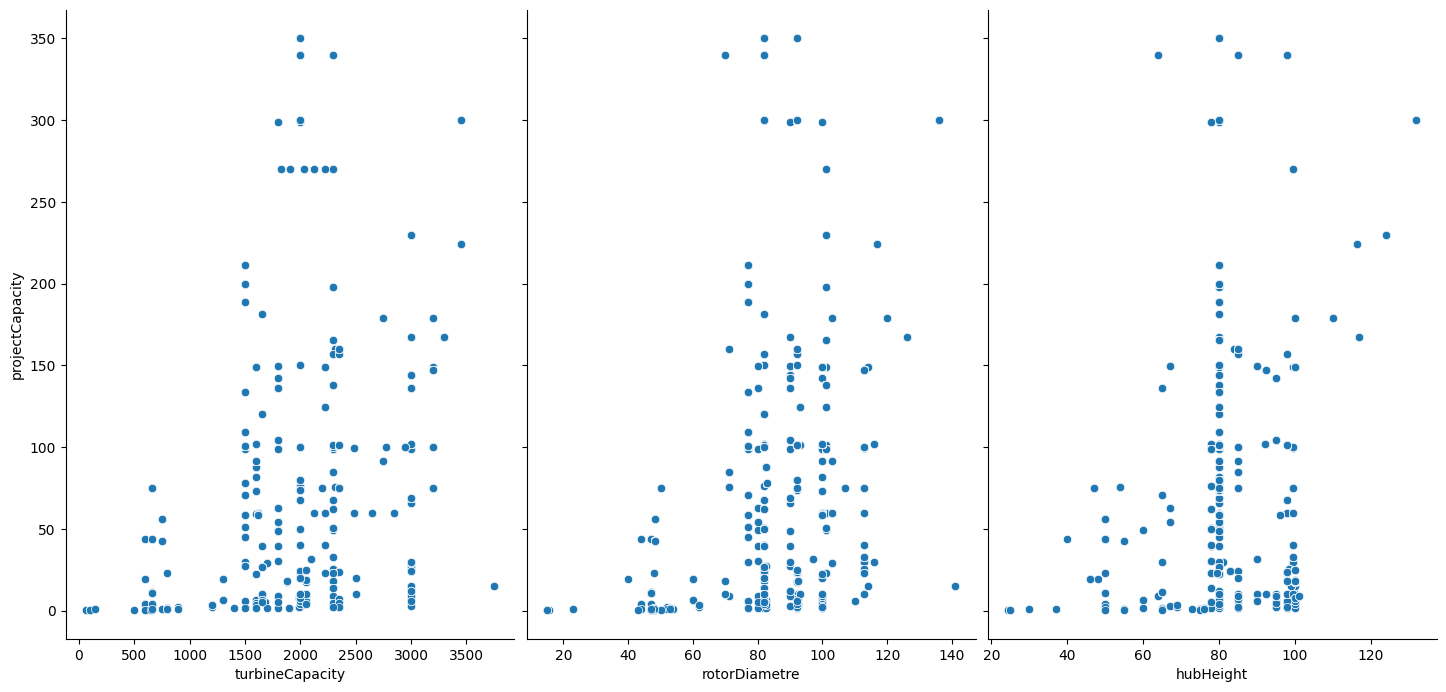

In [21]:
p = sns.pairplot(data, x_vars=['turbineCapacity','rotorDiametre','hubHeight'], y_vars='projectCapacity', size=7, aspect=0.7)

We can see here that none of our independent variables are linearly graphed.

2. Check mean of residuals

We will begin the regression portion of our analysis by loading our dataset and converting the 'turbineCapacity' column to numerical values whilst also dropping non-numerical values from the columns.

Through feature selection for our regression modelling process we determined that the turbines total capacity (on an individual level), the diameter of the rotor, and the height of the hub were the best independent variables to use when predicting the total project capacity.

In [22]:
X = data[['turbineCapacity', 'rotorDiametre', 'hubHeight']]
y = data['projectCapacity']
sc = StandardScaler()
X = sc.fit_transform(X)

x_train,x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

We will now fit the training set to the linear regression model and calculate the RMSE value.

In [25]:
# Creating a LinearRegression object
linear = LinearRegression()
linear.fit(x_train, y_train)
y_pred = linear.predict(x_test)
residuals = y_test - y_pred

mean_residuals = round(np.mean(residuals), 5)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -4.10163


It's not that close to the value of 0 so it does not pass this check.

In [10]:
accuracy = linear.score(x_test, y_test)
print("Testing Accuracy: ", accuracy)

print('Coefficient: \n', linear.coef_)
print('Intercept: \n', linear.intercept_)

rmse = mean_squared_error(y_test, y_pred, squared=False)

print('RMSE: ', rmse)

Testing Accuracy:  0.07434589892078813
Coefficient: 
 [ 1.54924638  0.92250782 23.92253208]
Intercept: 
 131.3856528638816
RMSE:  86.583648809547


3. Check for heteroscedasticity/homoscedasticity

In [26]:
X = data[['turbineCapacity', 'rotorDiametre', 'hubHeight']]
y = data['projectCapacity']
results = smf.ols("projectCapacity ~ turbineCapacity + rotorDiametre + hubHeight", data=data).fit()

np.linalg.cond(results.model.exog)

13091.024289455983

Use the 'Breush Pagan' test to help find the appropriate values to validate or deny the heteroscedasticity of the data.

In [27]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 55.0225567608543),
 ('p-value', 6.790509514949755e-12),
 ('f-value', 18.486547483505234),
 ('f p-value', 6.139534657807666e-12)]

The data model is not homoscedastic.

4. Check for multicollinearity

<Axes: >

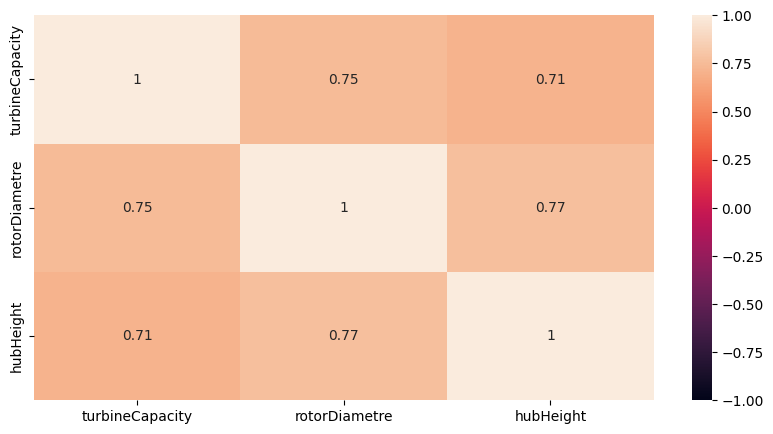

In [28]:
plt.figure(figsize=(10,5))
sns.heatmap(data[['turbineCapacity', 'rotorDiametre', 'hubHeight']].corr(),vmin=-1,annot= True)

In [14]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data[['turbineCapacity', 'rotorDiametre', 'hubHeight']].values, i) for i in range(X.shape[1])]
vif["features"] = data[['turbineCapacity', 'rotorDiametre', 'hubHeight']].columns
vif.round(1)

,VIF Factor,features
0,26.1,turbineCapacity
1,79.5,rotorDiametre
2,69.8,hubHeight


Very high VIF factors indicate that multi-collinearity exists.

5. Check for normality

<ipython-input-15-399e0398f458>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(residuals,kde=True)


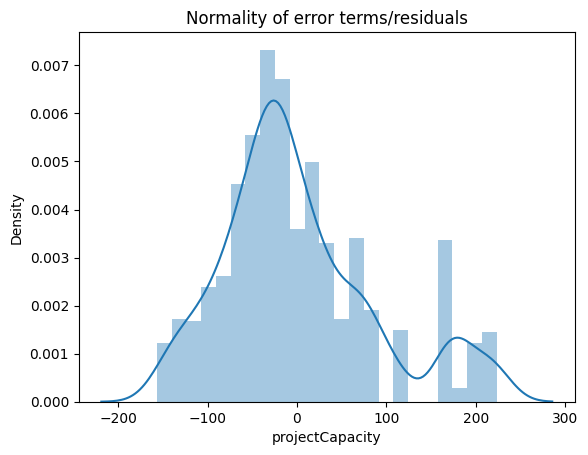

In [15]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

It does however follow the normal distribution.

6. Check for residual autocorrelation

In [16]:
model = smf.ols("projectCapacity ~ turbineCapacity + rotorDiametre + hubHeight", data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        projectCapacity   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     193.2
Date:                Sun, 30 Apr 2023   Prob (F-statistic):          5.20e-120
Time:                        21:13:54   Log-Likelihood:                -38051.
No. Observations:                6478   AIC:                         7.611e+04
Df Residuals:                    6474   BIC:                         7.614e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -16.9100      6.789     

In [ ]:
durbin_watson(model.resid)

0.03353105016518193

Autocorrelation within the residuals is present.

Since the linear regression model did not pass 5 out of the 6 assumptions (only normality was passed) we will move onto the polynomial regression instead.

We will now repeat the process for our polynomial regression modelling process.

In [17]:
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train R-squared score: {train_r2:.2f}")
print(f"Test R-squared score: {test_r2:.2f}")

Train R-squared score: 0.13
Test R-squared score: 0.11


Plotting the actual vs. the predicted values to evaluate the validity of the polynomial regression model.

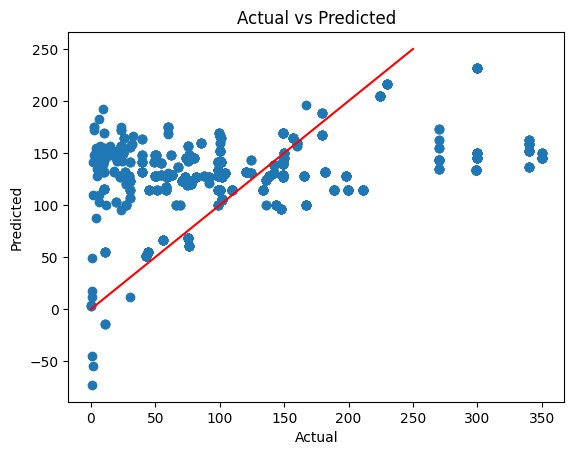

In [18]:
plt.scatter(y_test, y_test_pred)
plt.plot([0, 250], [0, 250], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

Using the data thus far, we can also apply the KNN classifier to our current modelling process to help discover a more optimal model for predicting the total project capacity. We will start by discretizing the total project capcity column into three separate categories, and from there we will split the data similarly in our earlier process. From here we will use a for-loop to help predict the class-labels of the test set and report the accuracy score. We have also provided a plot for easier evaluation of the model's testing accuracy.

Best accuracy score = 0.8094135802469136 for k = 8


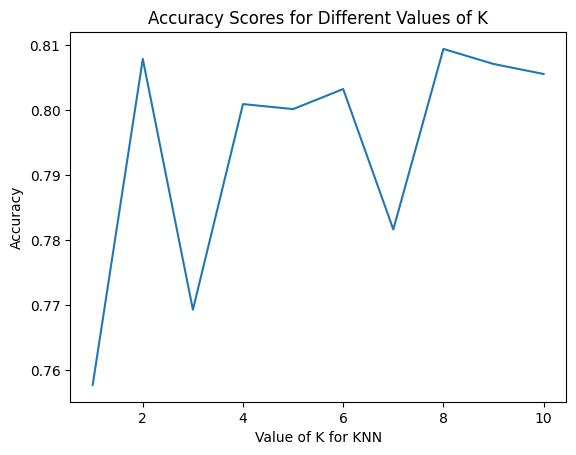

In [ ]:
data['projectCapacity'] = pd.cut(data['projectCapacity'], bins=[0, 50, 100, float('inf')], labels=['low', 'medium', 'high'])

data.dropna(inplace=True)

X = data[['turbineCapacity', 'rotorDiametre', 'hubHeight']]
y = data['projectCapacity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

k_range = range(1, 11)

accuracy_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    accuracy_scores.append(accuracy)

best_k = k_range[accuracy_scores.index(max(accuracy_scores))]
print(f"Best accuracy score = {max(accuracy_scores)} for k = {best_k}")

plt.plot(k_range, accuracy_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Values of K')
plt.show()

Lastly to optimize our regression models we have used the SVC approach (which will help to find which model is the most accurate for the regression component of our model selection process).

Here we will create the SVM model using a kernal 'rbf' then train our model similarly to our prior process and from there make predictions on the test data set whilst simultaneously gathering accuracy scores upon the test set. We will also print out a classification report to help support the validity of our model.

In [ ]:
svm_model = SVC(kernel='rbf')

svm_model.fit(x_train, y_train)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) #Normalize the data

X_test = scaler.transform(X_test) #Normalize the data

y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(classification_report(y_test, y_test_pred))

print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)
print('\n')

              precision    recall  f1-score   support

        high       0.54      1.00      0.70       696
         low       0.00      0.00      0.00       216
      medium       0.00      0.00      0.00       384

    accuracy                           0.54      1296
   macro avg       0.18      0.33      0.23      1296
weighted avg       0.29      0.54      0.38      1296

Training accuracy: 0.5482439212659205
Testing accuracy: 0.5370370370370371




/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Part II: Linear Discriminant Analysis

The main goal of this section is to help us to aim our focus towards only those specific variables or factors that are most important when contributing to our dataset. The aim of this section is to help us to reduce the number of independent variables that we will include in our dataset moving forward. We would also like to focalize our goal within this section so that we may have more specific algorithms for our problem statement.

We first begin by loading the necessary libraries needed to load the turbine dataset. We will also load the data and drop the 'Notes' column (as this column contains NA values and won't be useful to us moving forward). Similarly, we are eliminating the 'OBJECTID' column as we will be using another method for indexing.
For columns: 'Latitude', 'Longitude', 'Province/Territory', 'Project name'; we will come back to these variables when remarking on our analysis at the very end.

In [29]:
df = pd.read_csv("Turbine.csv")
df = df.drop("Notes", axis=1)
df = df.drop("OBJECTID", axis=1)
df = df.drop("Latitude", axis=1)
df = df.drop("Longitude", axis=1)
df = df.drop("Province/Territory", axis=1)
df = df.drop("Project name", axis=1)
df

,Total project capacity (MW),Turbine identifier,Turbine number in project,Turbine rated capacity (kW),Rotor diameter (m),Hub height (m),Manufacturer,Model,Commissioning date
0,0.90,OWE1,1/2,150,23.0,30.0,Bonus,AN 150/30,1993
1,44.00,CRW1,1/60,600,44.0,40.0,Vestas,V44/600,1997
2,3.78,WWT1,1/6,600,44.0,50.0,Vestas,V44/600,1998
3,3.78,WWT2,2/6,600,44.0,50.0,Vestas,V44/600,1998
4,3.78,WWT3,3/6,600,44.0,50.0,Vestas,V44/600,1998
...,...,...,...,...,...,...,...,...,...
6693,10.56,CYP14,14/16,660,47.0,50.0,Vestas,V47,2001/2003
6694,10.56,CYP15,15/16,660,47.0,50.0,Vestas,V47,2001/2003
6695,10.56,CYP16,16/16,660,47.0,50.0,Vestas,V47,2001/2003
6696,0.81,HAH1,1/2,150,23.0,30.0,Bonus,B23/150,1993


We will now begin with our first method of factor reduction which is by using the 'Linear Discriminant Analysis (LDA)' method. The LDA method allows us to look at our dataset from a hollistic approach and fundamentally reduce our dataset to only those specific factors that influence the classifications (and likewise predictions) found from the inevitable analysis of our turbine data.

The first step in the LDA process requires us to manipulate 2 of of our main categorical variables by combining both variables into one, more specific set of class; for our purposes here we will be transforming the data from string to categorical identifiers.

The columns that will need to be changed are as follows:

(1) Turbine Identifier

(2) Model

In [ ]:
df['TurbineModel'] = df['Turbine identifier'] + df['Model']

Now we can begin with splitting our dataset into training and test sets for the LDA process. Here we will be using the 'Commission date' column to help us grab information based on year and split according to a date filter that we will now create. Simultaneously we will also be removing inter-year commissioning date data as this allows us to have more concise years to work with when splitting our for further exploration.

In [ ]:
df = df.drop(df[df['Commissioning date'] == '2000/2001'].index)
df = df.drop(df[df['Commissioning date'] == '2006/2007'].index)
df = df.drop(df[df['Commissioning date'] == '2005/2006/2012'].index)
df = df.drop(df[df['Commissioning date'] == '2004/2005'].index)
df = df.drop(df[df['Commissioning date'] == '2002/2006'].index)
df = df.drop(df[df['Commissioning date'] == '2006/2008'].index)
df = df.drop(df[df['Commissioning date'] == '2004/2005'].index)
df = df.drop(df[df['Commissioning date'] == '2011/2012'].index)
df = df.drop(df[df['Commissioning date'] == '2013/2014'].index)
df = df.drop(df[df['Commissioning date'] == '2014/2015'].index)
df = df.drop(df[df['Commissioning date'] == '2001/2003'].index)
df = df.drop(df[df['Commissioning date'] == '2001/2003'].index)
df = df.drop(df[df['Turbine rated capacity (kW)'] == '1815/1950'].index)
df = df.drop(df[df['Turbine rated capacity (kW)'] == '1903/2126/2221'].index)
df = df.drop(df[df['Turbine rated capacity (kW)'] == '1800-2300'].index)
df

,Total project capacity (MW),Turbine identifier,Turbine number in project,Turbine rated capacity (kW),Rotor diameter (m),Hub height (m),Manufacturer,Model,Commissioning date,TurbineModel
0,0.90,OWE1,1/2,150,23.0,30.0,Bonus,AN 150/30,1993,OWE1AN 150/30
1,44.00,CRW1,1/60,600,44.0,40.0,Vestas,V44/600,1997,CRW1V44/600
2,3.78,WWT1,1/6,600,44.0,50.0,Vestas,V44/600,1998,WWT1V44/600
3,3.78,WWT2,2/6,600,44.0,50.0,Vestas,V44/600,1998,WWT2V44/600
4,3.78,WWT3,3/6,600,44.0,50.0,Vestas,V44/600,1998,WWT3V44/600
...,...,...,...,...,...,...,...,...,...,...
6677,20.00,WLY8,8/10,2000,82.0,85.0,Enercon,E-82,2019,WLY8E-82
6678,20.00,WLY9,9/10,2000,82.0,85.0,Enercon,E-82,2019,WLY9E-82
6679,20.00,WLY10,10/10,2000,82.0,85.0,Enercon,E-82,2019,WLY10E-82
6696,0.81,HAH1,1/2,150,23.0,30.0,Bonus,B23/150,1993,HAH1B23/150


For our convenience moving further we will now rename our columns and drop the columns that were used to created the new, combined column.

In [ ]:
df = df.rename(columns={'Province/Territory':'PT', 'Project name':'PN', 'Total project capacity (MW)': 'TPC', 'Turbine number in project': 'TNP', 'Turbine rated capacity (kW)': 'TRC', 'Rotor diameter (m)': 'RD', 'Hub height (m)': 'HH', 'Manufacturer': 'MU', 'Model': 'MO', 'Commissioning date': 'CD', 'Latitude': "LA", "Longitude":"LO", "Turbine identifier": "TI"})
df[["TNPN", "TNPD"]] = df["TNP"].str.split("/", expand=True)
df = df.drop('TNP', axis=1)
df = df.drop('TI', axis=1)
df = df.drop('MO', axis=1)
df['MU2'] = pd.factorize(df['MU'])[0]
df

,TPC,TRC,RD,HH,MU,CD,TurbineModel,TNPN,TNPD,MU2
0,0.90,150,23.0,30.0,Bonus,1993,OWE1AN 150/30,1,2,0
1,44.00,600,44.0,40.0,Vestas,1997,CRW1V44/600,1,60,1
2,3.78,600,44.0,50.0,Vestas,1998,WWT1V44/600,1,6,1
3,3.78,600,44.0,50.0,Vestas,1998,WWT2V44/600,2,6,1
4,3.78,600,44.0,50.0,Vestas,1998,WWT3V44/600,3,6,1
...,...,...,...,...,...,...,...,...,...,...
6677,20.00,2000,82.0,85.0,Enercon,2019,WLY8E-82,8,10,3
6678,20.00,2000,82.0,85.0,Enercon,2019,WLY9E-82,9,10,3
6679,20.00,2000,82.0,85.0,Enercon,2019,WLY10E-82,10,10,3
6696,0.81,150,23.0,30.0,Bonus,1993,HAH1B23/150,1,2,0


We will now split the dataset into training and test sets by using the year 2006 as a main condition for filtering. 2006 is halfway between 1993 and 2019 (the start and end years of our data) and thus we felt that this filtering would best allow us to split the data in such a way that our models would be capturing the past (more historical data) more accurately when making predictions on more contempory data.

In [ ]:
X = df[['TPC', 'TRC', 'RD', 'HH']]
y = df['MU']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Discriminant Analysis (LDA)

Before we begin modelling our dataset with LDA model, we will first check all of the LDA assumptions.

1. Check for independent samples

In [ ]:
summary, results = rp.ttest(group1= df['TPC'][df['MU'] == 'Enercon'], group1_name= "E",
         group2= df['TPC'][df['MU'] == 'Vestas'], group2_name= "V")
print(summary)
print(results)

   Variable       N        Mean         SD        SE   95% Conf.    Interval
0         E   774.0   96.317959  64.336979  2.312545   91.778346  100.857571
1         V  1596.0  138.288891  87.557484  2.191678  133.990018  142.587764
2  combined  2370.0  124.581928  83.064908  1.706253  121.236024  127.927832
          Independent t-test    results
0      Difference (E - V) =    -41.9709
1      Degrees of freedom =   2368.0000
2                       t =    -11.8715
3   Two side test p value =      0.0000
4  Difference < 0 p value =      0.0000
5  Difference > 0 p value =      1.0000
6               Cohen's d =     -0.5200
7               Hedge's g =     -0.5198
8          Glass's delta1 =     -0.6524
9        Point-Biserial r =     -0.2370


/usr/local/lib/python3.9/dist-packages/researchpy/ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


There is a statistically significant difference in the average turbine rotor capacity amongst Enercon and Vestas, p= 0.0000.

2. Check for normality amongst predictors

We will first start by creating an LDA object, then from there we will create our projection matrix, we will use this model to project X which will then give us the predicted label for each sample and likewise the probabilities of each sample belonging to each class. This is specifically for the training process.

In [ ]:
model = LDA()
model.fit(X_train, y_train)
model.explained_variance_ratio_

array([0.55700029, 0.32334764, 0.07452095, 0.04513111])

From here we will now use a repeated stratified k-fold method to help provide a way to improve the estimated performance of our machine learning model. This involves simply repeating the cross-validation procedure (as many times as we need to) multiple times and reporting the mean result across all folds from all runs. We will also print out the accuracy of the current LDA model.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores_te = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_te))   

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.5201722503160556


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [ ]:
X = df[['TPC', 'TRC', 'RD', 'HH']]
y = df['MU']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
X = sc.fit_transform(X)

lda = LDA(n_components=2)
lda_object = lda.fit(X, y)
X = lda_object.transform(X)

y_pred = model.predict(X_test)
print("Testing Accuracy: ", accuracy_score(y_test,y_pred))

confusion_matrix(y_test,y_pred)

Testing Accuracy:  0.5142602495543672


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   6,   0,   0,   0,   0,   0,   0,   3,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  3,   0,   0, 103,   1,   0,   2,   0,   0,   0,   0,   0,   0,
          0,  56,   0],
       [  0,   0,   0,  12, 224,   0,   0,   0,   0,   0,   0,  12,   0,
          0,  45,   0],
       [  0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  24,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   4,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          0,   0,   0],
       [  0,   0,   0,   0,  3

Accuracies are similar in both cases (marginal differences).

<ipython-input-80-5633bb9f20c1>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(df['HH'],kde=True)


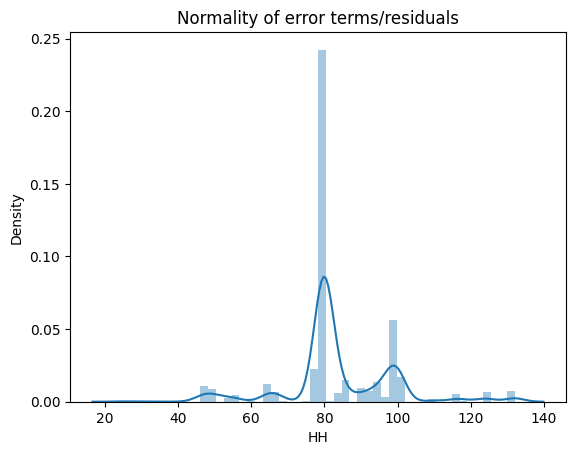

In [ ]:
np.random.seed(1)

p = sns.distplot(df['HH'],kde=True)
p = plt.title('Normality of error terms/residuals')

<ipython-input-81-6e74718bb4a4>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(df['TPC'],kde=True)


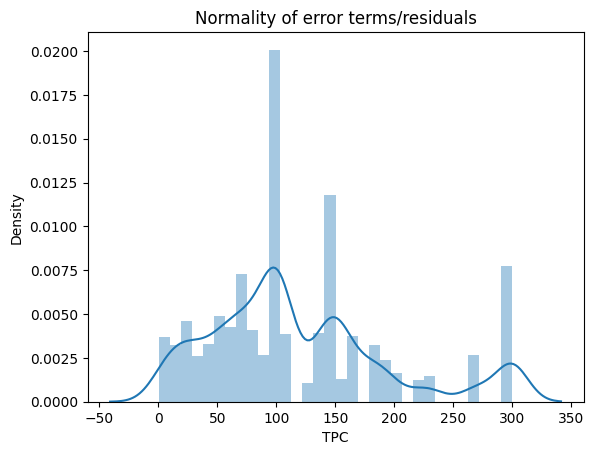

In [ ]:
np.random.seed(1)

p = sns.distplot(df['TPC'],kde=True)
p = plt.title('Normality of error terms/residuals')

<ipython-input-82-7c5bbb055e5a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(df['TRC'],kde=True)


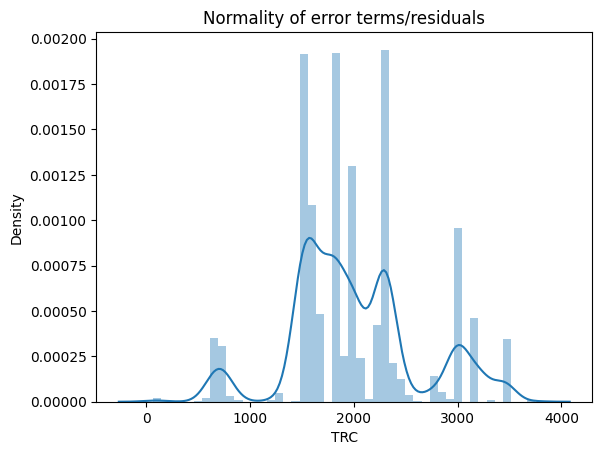

In [ ]:
np.random.seed(1)

p = sns.distplot(df['TRC'],kde=True)
p = plt.title('Normality of error terms/residuals')

<ipython-input-83-16e79f27ae6f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(df['RD'],kde=True)


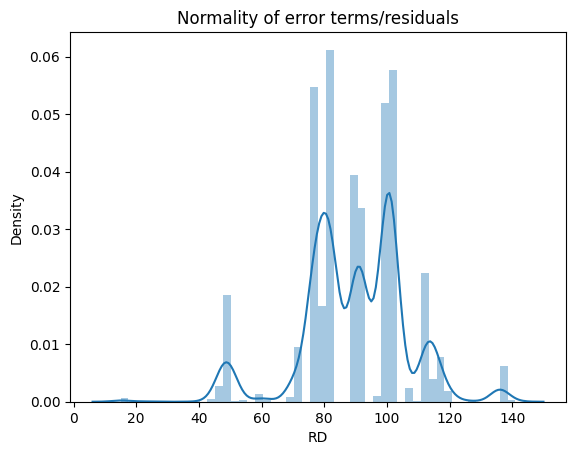

In [ ]:
np.random.seed(1)

p = sns.distplot(df['RD'],kde=True)
p = plt.title('Normality of error terms/residuals')

By visual estimates we have determined that all of our predictors follow the normal distribution.

3. Check for mutual exclusivity

The following function will help to determine the mutual exclusivity amongst all of our predictors (anything greater than 0 indicates that the predictor variable is not mutually exclusive).

In [ ]:
def Vfold_Subsets(Data, V):
    return Data.assign(
        V=np.random.permutation(np.arange(len(Data))) % V)

In [ ]:
subset_df = Vfold_Subsets(df, 5)
subset_df

,TPC,TRC,RD,HH,MU,CD,TurbineModel,TNPN,TNPD,MU2,V
0,0.90,150,23.0,30.0,Bonus,1993,OWE1AN 150/30,1,2,0,1
1,44.00,600,44.0,40.0,Vestas,1997,CRW1V44/600,1,60,1,4
2,3.78,600,44.0,50.0,Vestas,1998,WWT1V44/600,1,6,1,0
3,3.78,600,44.0,50.0,Vestas,1998,WWT2V44/600,2,6,1,0
4,3.78,600,44.0,50.0,Vestas,1998,WWT3V44/600,3,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...
6677,20.00,2000,82.0,85.0,Enercon,2019,WLY8E-82,8,10,3,0
6678,20.00,2000,82.0,85.0,Enercon,2019,WLY9E-82,9,10,3,2
6679,20.00,2000,82.0,85.0,Enercon,2019,WLY10E-82,10,10,3,0
6696,0.81,150,23.0,30.0,Bonus,1993,HAH1B23/150,1,2,0,0


From the 'V' column in can be determined that all predictors have some level mutual inclusiveness (not exclusivity).

As such the LDA model was able to clearly pass 2 out of 3 assumptions (the mutual exclusivity one being the only one that was not passed).

Conclusions:

The accuracy of 52.02% can be interpreted as the value that is associated with this current model that can accurately predit the test set. More simply put, currently our model is 52.90% accurate when predicting the values or data of the test set.

The accuracy here initially is 52.02%, although this is not the most optimal model for our algorithmic approach we can see that by utilizing these variables alongside further optimality models we will be able to greatly increase this accuracy level to its highest. 

The linear Discriminant analysis estimates the probability that a new set of inputs belongs to every class within our dataset. The output class is the one that has the highest probability. That is how the LDA makes its prediction. However, as we can evaluate from our plot, it is increasingly more difficult to make a decision based on the graph. Another model will be needed to help us with the decision-making process of our analysis (A.K.A Decision Tree analysis will be needed). We can, however, surmise that the manufacturer 'Enercon' is quite common amongst a majority of the turbine projects. This indicates that the projects that have relied on Enercon's turbines have provided enough value to the projects total capacity rating for it to be re-used multiple times over.

In this section we determined that our most important variables are as follows:

1) Indepedent Variables: 'Total Project Capacity (MW)', 'Total Rated Capacity (kW)', 'Rotor Diameter (m)', and 'Hub Height (m)'

2) Dependent Variables: 'Manufacturer'

Moving forward from sections II to IV we will be using these independent and dependent variables for our feature selections.

#Part III: Classification Modeling

The main goal of this second section is to help us to aim our focus towards only those optimal models that are most important when contributing to modelling our dataset. The aim of this section is to help us to reduce the number of models that can aid us in fitting our dataset with its respective classes, and in the process, to help us reach the highest level of accuracy possible within our model selection process.

K-Nearest Neighbour Classification

We begin by using the KNN classification method. From section I we continue to create splits based off of our featured selection and labels.

In [ ]:
X = df[['TPC', 'TRC', 'RD', 'HH']]
y = df['MU']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We then apply the KNN classifier to the training dataset

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

We then predict our test set.

In [ ]:
y_pred = knn.predict(X_test)

Then we calculate the test accuracy for our dataset using the KNN classifier.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", accuracy)

Testing Accuracy: 0.9901960784313726


Gaussian Naive Bayes Classification

We weill now be using the Gaussian Naived Bayes classification method. From section I we continue to create splits based off of our featured selection and labels.

In [ ]:
X = df[['TPC', 'TRC', 'RD', 'HH']]
y = df['MU']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will now use the Gaussian Naive Bayes model and fit it to our training set.

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

Likewise, we will also print out the predicted values.

In [ ]:
y_pred = nb.predict(X_test)

We will also calculate the testing set's accuracy once again.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", accuracy)

Testing Accuracy: 0.5935828877005348


Multi-nomial Classification

Lastly, we will repeat the process once more for our Multi-nomial Classification model. Beginning with the same train/test split as before.

In [ ]:
X = df[['TPC', 'TRC', 'RD', 'HH']]
y = df['MU']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will now apply the Multi-nomial Naive Bayes model to our dataset.

In [ ]:
me = MultinomialNB()
me.fit(X_train, y_train)

MultinomialNB()

Once more, we will get the 'y' predicted values from our model.

In [ ]:
y_pred = me.predict(X_test)

Lastly, we will print out the testing accuracy scores for the Mult-nomial Classification model.

In [ ]:
print("Testing Accuracy: ", accuracy_score(y_test, y_pred))

Testing Accuracy:  0.2967914438502674


Conclusions:

From this section when we evaluate each of our models we are aiming to discover the highest level of accuracy when predicting the classification labels of our turbine datasets manufacturers' class.

The models are order below (from highest to lowest accuracy - thus far):

1. KNN Model - 99.01%
2. Gaussian Naive Bayes - 59.36%
3. Linear Discriminant Analysis - 52.02% 
4. Multi-nomial Model - 29.68%


We find from our analysis thus far that the highest accuracy is achieved from our KNN model, with a descrepancy of 40-60% when compare to the other 3 remaining models. KNN is most useful in this case because the labeled data is too expensive or impossible to obtain, and it can achieve high accuracy in a wide variety of prediction-type problems associated with the turbines' information. KNN is a simple algorithm, based on the local minimum of the target function which is used to learn an unknown function of desired precision and accuracy of our turbine labels.

It should be mentioned that models such as the Multi-nomial based fitting would not work well with this particular dataset because the multinomial naïve Bayes is more commonly used for assigning documents or records to classes based on the statistical analysis of their contents. It provides an alternative to the "heavy" AI-based analysis and drastically simplifies 'TEXTUAL' data classification (thus not particularly powerful or useful with other forms of data classifications).


#Part IV: Decision Tree Analysis

Decision Tree Classification

The main goal of this third section is to help us to aim our focus towards helping us to focalize our efforts towards models that balance optimal accuracy with decision-making ability. The aim of this section is to once again help us to reduce the number of models that can aid us in fitting our dataset with its respective classes, and in the process, to help us reach the highest level of accuracy possible within our model selection process.

We once again begin by splitting our data as we had done in prior sections.

In [ ]:
feature_cols = ['TPC', 'TRC', 'RD', 'HH']
cn = df['MU']

X = df[['TPC', 'TRC', 'RD', 'HH']]
y = df['MU']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We then apply our Decision Tree Classification model to fit to our training data.

In [ ]:
clf = DecisionTreeClassifier()

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

We will also pring out the testing set's accuracy.

In [ ]:
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred))

Testing Accuracy: 0.9973262032085561


From here we will create the decision tree map and analyze which pathway is most effective when selecting manufacturers for turbine designs within component selection for projects.

For a closer look into our decision tree please download and open the 'decisiontreeclassification.png' file from your device.

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,15), dpi=700)

tree.plot_tree(clf,
               feature_names = feature_cols, 
               class_names=cn,
               filled = True)

fig.savefig('decisiontreeclassification.png')

Conclusions:

From this section when we evaluate each of our models we are aiming to discover the highest level of accuracy when predicting the classification labels of our turbine datasets manufacturers' class.

The models are order below (from highest to lowest accuracy - thus far):

1. Decision Tree Model - 99.73%
2. KNN Model - 99.01%
2. Gaussian Naive Bayes - 59.36%
3. Linear Discriminant Analysis - 52.02% 
4. Multi-nomial Model - 29.68%



From our decision tree classification diagram and model we have concluded that the 3 main major manufacturers who have contributed the most to the total capacity and power generated output of the total collection of projects are as follows:

1. Enercon
2. Nordex
3. GE
4. Vestas
5. Siemens

Taken altogether our analysis has indicated that the decision-tree classification model is the most optimal and accurate model when predicting class labels for the turbines' manufacturers. When evaluating which paths to follow organizations will have to balance the predictors that are most desparately coveted (for example if an organization wanted the highest TPC values with the highest TRC values they would choose the longest path on our decision tree diagram as this would occur only when the HH and RD values are most optimized or at their highest).

#Part V: Alternative Approach to Model Accuracy - Neural Network Class-Label Classification

We would like to conclude our analysis with an alternative approach to model creation (outside of our main models and the most optimal model selected prior). This approach requires the use of model sequentially created layers that will help us to iterate through and check the losses of accuracy through each epoch of our iteration (concluding with a final model and accuracy level). Although we have already concluded that the decision tree classifier is the most optimal model for our data we wanted to expand our analysis to this alternative strategy (though it may prove less accurate). This portion of the analysis will also look at the concept of overfitting and how this plays a major role when predicting the dataset's class labels.

We will split the data as common with prior sections and we will also reshape as well as transform the labels' data.

In [ ]:
X = df[['TPC', 'TRC', 'RD', 'HH']].astype('float')
y = df['MU']

encoder = OneHotEncoder()

encoded_Y = encoder.fit(y.values.reshape(-1,1))
encoded_Y = encoded_Y.transform(y.values.reshape(-1,1)).toarray()

encoded_Y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

We will now create various splits for training, testing, and validation sets whilst simultaneously creating these splits.

In [ ]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

trainX, testX, trainY, testY = train_test_split(X, encoded_Y, test_size= 1 - train_ratio)
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

We want to find the unique counts of all of our class labels.

In [ ]:
y_part = [trainY, valY, testY]

for y_part in y_part:
    re_transformed_array = encoder.inverse_transform(y_part)
    
    unique_elements, counts_elements = np.unique(re_transformed_array, return_counts=True)
    unique_elements_and_counts = pd.DataFrame(np.asarray((unique_elements, counts_elements)).T)
    unique_elements_and_counts.columns = ['unique_elements', 'count']
    print('---------------')
    print(unique_elements_and_counts)

---------------
             unique_elements count
0                    Acciona    24
1         Acciona Wind Power    32
2                      Bonus     2
3                     DeWind     4
4                        EWT     1
5                    Enercon   526
6                         GE  1035
7                     Gamesa     7
8                   Lagerwey     2
9                   Leitwind     1
10                 NEG Micon   100
11                    Nordex    10
12                 Northwind     3
13                Pfleiderer     1
14  Samsung Renewable Energy     2
15                   Senvion   338
16                   Siemens   706
17                    Suzlon    10
18                Turbowinds     1
19                    Vensys     7
20                    Vestas  1109
21                 Windmatic     5
---------------
             unique_elements count
0                    Acciona     7
1         Acciona Wind Power     5
2                     DeWind     1
3                    En

We are now going to be creating vectors to help configure our neural network model creation process.

In [ ]:
checkpoint_no = 'ckpt_1_ANN'
model_name = 'DATA607ProjectNN'

input_shape = trainX.shape[1]

n_batch_size = 20

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 25

num_classes = trainY.shape[1]

print('Input Shape: ' + str(input_shape))
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))
print()
print('Number of Classes: ' + str(num_classes))

Input Shape: 4
Batch Size: 20

Steps per Epoch: 196

Validation Steps: 42
Test Steps: 42

Number of Epochs: 25

Number of Classes: 23


We will now create the model using our configured settings.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

We will also print out the information associated with the layers, output shapes, and unique parameters associated with our data.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 23)                1495      
                                                                 
Total params: 5,975
Trainable params: 5,975
Non-trainable params: 0
_________________________________________________________________


We will now compile the model using categorical analysis and accuracy training metrics.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

We will also create a checkpoint directory for our model and analysis moving forward.

In [ ]:
checkpoint_dir = './'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

We will create a vector that will contain the model checkpoint analysis output and store it in the checkpoint directory.

In [ ]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

We will now fit our model with all configuration settings inplace.

In [ ]:
history = model.fit(trainX,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

Epoch 1/25
190/196 [============================>.] - ETA: 0s - loss: 18.3260 - accuracy: 0.2058

196/196 [==============================] - 2s 8ms/step - loss: 17.8681 - accuracy: 0.2048 - val_loss: 2.9827 - val_accuracy: 0.2917
Epoch 2/25
196/196 [==============================] - 0s 2ms/step - loss: 3.8823 - accuracy: 0.2819 - val_loss: 3.3357 - val_accuracy: 0.1750
Epoch 3/25
170/196 [=========================>....] - ETA: 0s - loss: 3.4697 - accuracy: 0.3015

196/196 [==============================] - 1s 5ms/step - loss: 3.4621 - accuracy: 0.2988 - val_loss: 2.0130 - val_accuracy: 0.3821
Epoch 4/25
168/196 [========================>.....] - ETA: 0s - loss: 2.7699 - accuracy: 0.3036

196/196 [==============================] - 1s 7ms/step - loss: 2.8056 - accuracy: 0.3062 - val_loss: 1.9302 - val_accuracy: 0.3286
Epoch 5/25
196/196 [==============================] - 0s 2ms/step - loss: 2.7136 - accuracy: 0.3105 - val_loss: 2.5768 - val_accuracy: 0.2952
Epoch 6/25
196/196 [==============================] - 0s 2ms/step - loss: 2.4087 - accuracy: 0.3146 - val_loss: 2.6266 - val_accuracy: 0.3143
Epoch 7/25
166/196 [========================>.....] - ETA: 0s - loss: 2.5023 - accuracy: 0.3079

196/196 [==============================] - 1s 5ms/step - loss: 2.4707 - accuracy: 0.3123 - val_loss: 1.6271 - val_accuracy: 0.4560
Epoch 8/25
196/196 [==============================] - 0s 2ms/step - loss: 2.3776 - accuracy: 0.3203 - val_loss: 1.6524 - val_accuracy: 0.3536
Epoch 9/25
196/196 [==============================] - 0s 2ms/step - loss: 2.2681 - accuracy: 0.3382 - val_loss: 2.0378 - val_accuracy: 0.3750
Epoch 10/25
196/196 [==============================] - 0s 2ms/step - loss: 2.6895 - accuracy: 0.3326 - val_loss: 1.6788 - val_accuracy: 0.4714
Epoch 11/25
196/196 [==============================] - 0s 2ms/step - loss: 2.1729 - accuracy: 0.3607 - val_loss: 1.8209 - val_accuracy: 0.3381
Epoch 12/25
179/196 [==========================>...] - ETA: 0s - loss: 2.1403 - accuracy: 0.3533

196/196 [==============================] - 1s 5ms/step - loss: 2.1200 - accuracy: 0.3548 - val_loss: 1.4311 - val_accuracy: 0.3798
Epoch 13/25
196/196 [==============================] - 0s 2ms/step - loss: 2.0651 - accuracy: 0.3889 - val_loss: 2.4906 - val_accuracy: 0.3095
Epoch 14/25
196/196 [==============================] - 0s 2ms/step - loss: 2.2010 - accuracy: 0.3548 - val_loss: 1.6953 - val_accuracy: 0.4238
Epoch 15/25
196/196 [==============================] - 0s 2ms/step - loss: 2.1474 - accuracy: 0.3607 - val_loss: 1.9845 - val_accuracy: 0.3250
Epoch 16/25
196/196 [==============================] - 0s 2ms/step - loss: 2.0286 - accuracy: 0.3635 - val_loss: 1.6087 - val_accuracy: 0.4071
Epoch 17/25
196/196 [==============================] - 0s 2ms/step - loss: 1.7665 - accuracy: 0.3958 - val_loss: 1.7136 - val_accuracy: 0.3976
Epoch 18/25
196/196 [==============================] - 0s 2ms/step - loss: 1.7634 - accuracy: 0.4114 - val_loss: 2.0277 - val_accuracy: 0.3655
Epoch 19/25

196/196 [==============================] - 1s 5ms/step - loss: 1.8817 - accuracy: 0.3881 - val_loss: 1.4227 - val_accuracy: 0.4702
Epoch 20/25
196/196 [==============================] - 0s 2ms/step - loss: 1.8205 - accuracy: 0.4132 - val_loss: 1.6474 - val_accuracy: 0.4131
Epoch 21/25
196/196 [==============================] - 0s 2ms/step - loss: 1.6459 - accuracy: 0.4250 - val_loss: 1.7928 - val_accuracy: 0.3857
Epoch 22/25
182/196 [==========================>...] - ETA: 0s - loss: 1.6415 - accuracy: 0.4178

196/196 [==============================] - 1s 6ms/step - loss: 1.6362 - accuracy: 0.4232 - val_loss: 1.2925 - val_accuracy: 0.4750
Epoch 23/25
196/196 [==============================] - 0s 2ms/step - loss: 1.7866 - accuracy: 0.4265 - val_loss: 1.4066 - val_accuracy: 0.4464
Epoch 24/25
196/196 [==============================] - 0s 2ms/step - loss: 1.7698 - accuracy: 0.4201 - val_loss: 1.3113 - val_accuracy: 0.4048
Epoch 25/25
196/196 [==============================] - 0s 2ms/step - loss: 1.6153 - accuracy: 0.4201 - val_loss: 1.7676 - val_accuracy: 0.3929


Print out a dataframe containing all of the accuracies and losses.

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,accuracy,val_loss,val_accuracy
0,1,17.868114,0.204847,2.982678,0.291667
1,2,3.882293,0.281874,3.335669,0.175000
2,3,3.462075,0.298771,2.012960,0.382143
3,4,2.805586,0.306196,1.930153,0.328571
4,5,2.713579,0.310548,2.576783,0.295238


Find the highest accuracy.

In [ ]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
21,22,1.636243,0.423195,1.292462,0.475


Find the class-label assignment for the highest accuracy.

In [ ]:
class_assignment = dict(zip(y, encoded_Y))

df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_temp = df_temp.stack()
df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']

df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

print('Class assignment:')
class_assignment

Class assignment:


{'Bonus': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'Vestas': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0.]),
 'Nordex': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'Enercon': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'GE': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'Lagerwey': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'Gamesa': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'Siemens': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0.]),
 'Leitwind': array([0., 0., 0., 0., 0., 0

Plot the accuracies and class-label assignments.

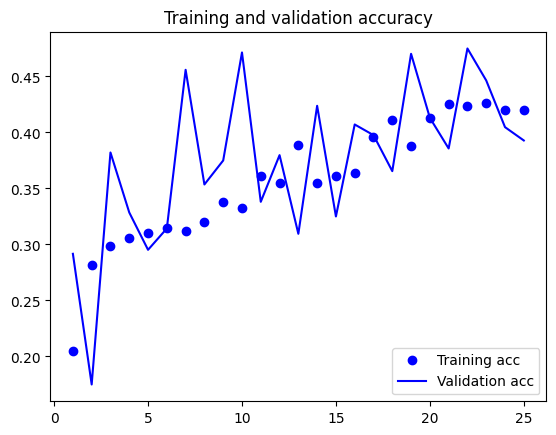

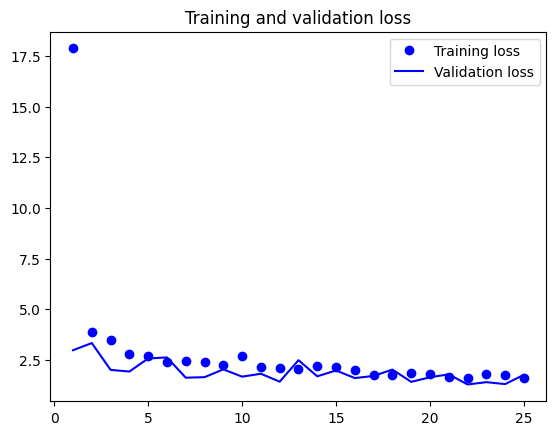

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In the following cells we will be re-loading our best model, then we will test our model using test data and then we will be reporting the testing accuracy alongside the predicted 'y' values.

In [ ]:
model_reloaded = load_model(checkpoint_no + '/' + model_name)

root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

In [ ]:
best_model = load_model(model_name_temp)

In [ ]:
test_loss, test_acc = best_model.evaluate(testX,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

40/42 [===========================>..] - ETA: 0s - loss: 1.3800 - accuracy: 0.4679

42/42 [==============================] - 0s 3ms/step - loss: 1.3805 - accuracy: 0.4667

Test Accuracy: 0.46674585342407227


In [ ]:
y_pred = model.predict(testX)
y_pred[:5]

27/27 [==============================] - 0s 1ms/step


array([[1.02243456e-03, 5.61774895e-03, 8.40012058e-20, 5.37169262e-06,
        6.73010714e-09, 1.19179615e-03, 4.09707934e-01, 1.77162699e-03,
        3.13163446e-06, 5.92550577e-07, 1.83565092e-08, 3.81557737e-04,
        9.00175268e-10, 8.58735305e-10, 2.89360090e-04, 3.97022851e-02,
        6.19429536e-02, 4.14630704e-05, 2.91588445e-16, 4.36476855e-10,
        2.65837316e-05, 4.78295058e-01, 4.26458907e-16],
       [9.22871812e-04, 1.37960666e-03, 4.89201869e-32, 5.48010519e-07,
        9.67861249e-14, 9.37477872e-03, 8.19349661e-02, 4.79316397e-04,
        2.26120078e-09, 2.87709021e-08, 1.42126043e-13, 3.42479616e-05,
        4.03079480e-13, 1.34330156e-13, 3.12337215e-05, 3.03714722e-02,
        4.53059599e-02, 1.08323184e-06, 2.93970862e-21, 5.67121169e-15,
        3.63158620e-06, 8.30160260e-01, 6.42058584e-24],
       [2.55603623e-03, 8.32493126e-04, 1.03670027e-34, 8.43995224e-07,
        2.56581420e-15, 4.44111973e-02, 1.77534614e-02, 4.33012290e-04,
        5.62001390e-10


In this study we have used various machine learning methods such as LDA/QDA, Regression, KNN Classification, SVM, Cross Validation, Grid Search Optimization, and Gaussian Bayes/Naïve Bayes/Multinomial Classifications. The purpose of this study was to provide insights into optimizing wind turbine power generation and potentially into improving the efficiency and effectiveness of wind energy production in Canada.

The process of power generation from wind turbines is complex and involves multiple interacting variables, including wind speed, blade pitch, and rotor speed. Capturing the complex system dynamics in a machine learning model can be difficult, and inaccurate or incomplete models can lead to suboptimal performance.

There are various challenges and limitations when using machine learning models to optimize turbine power generation. These challenges include the lack of complete data, the difficulty in accurately modeling complex systems, and the need for accurate and timely data. 

To address these challenges, researchers may need to explore different data sources and employ advanced modeling techniques, such as deep learning or ensemble models. It is also important to develop new methods for data collection and validation, and to continually refine and improve models as new data becomes available. Additionally, collaboration between different stakeholders, such as researchers, industry experts, and policymakers, may be necessary to address these challenges and develop effective solutions.

Incase of this dataset we can see that there are limited number of features in the dataset. The dataset do not contain all the relevant variables that affect turbine power generation, such as wind speed, wind direction, and air density. To address this limitation, additional data sources may need to be integrated, or more advanced feature engineering techniques may need to be employed.

Machine learning models such as neural networks, decision trees or support vector machines can be used to address  the modeling of complex and nonlinear relationships between the features and the target variable.

It is important to continuously evaluate the performance of the machine learning models and adjust it accordingly. This can be done by monitoring the accuracy, precision, and recall of the model and fine-tuning it as necessary.

#Bibliography (APA 6th Edition)

AnalyticsVidhya. (AnalyticsVidhya, 2021). Retrieved from
https://www.analyticsvidhya.com/blog/2021/08/a-brief-introduction-to-linear-discriminant-analysis/#:~:text=Assumptions%3A,classes%20has%20identical%20covariance%20matrices

<br>

Michael Fuchs Python. (Michael Fuchs, 2021). NN – Artificial Neural Network for Multi-Class Classfication. Retrieved
https://michael-fuchs-python.netlify.app/2021/02/23/nn-artificial-neural-network-for-multi-class-classfication/#loading-the-libraries

<br>

Open Canada. (Government of Canada, 2020). Canadian Wind Turbine Dataset. Retrieved from
from https://open.canada.ca/data/en/dataset/79fdad93-9025-49ad-ba16-c26d718cc070

<br>

PythonForDataScience. (PythonForDataScience, 2023). Retrieved from, https://www.pythonfordatascience.org/independent-samples-t-test-python/#test_with_python.

<br>

StackOverflow. (StackOverflow 2020). Retrieved from
https://stackoverflow.com/questions/42867080/split-pandas-dataframe-into-mutually-exclusive-subsets

<br>

StatsModels. (StatsModels, 2020). Regression diagnostics. Retrieved from 
https://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html

<br>

University of Calgary. (Qingrun Zhang, 2023). DATA 607 Lecture Notes. Retrieved from 
https://d2l.ucalgary.ca/d2l/le/content/500636/Home